In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import subprocess
import numpy as np

# Concat each TFs output

In [6]:
data_path     = "/global/homes/v/vsevim/scratch/ML/grammar/data/"
multidap_path = data_path + "multidap/"

df_tf               = pd.read_csv(data_path + "TF_Nos.TXT", names=['tf_no'], dtype={'tf_no':str})
df_dap_index        = pd.read_csv("../data/index_to_species.tsv", sep='\t', names=['tag', 'species'])
dap_index_to_genome = df_dap_index.set_index('tag')['species'].to_dict()

# For each TF, extract sequences of top 10 peaks from each genome

In [4]:
for i, tf_no in enumerate(df_tf.tf_no.values):
    summit_file_paths =  glob(multidap_path + tf_no + "_?-*????????+????????/*summits_blist_top10.narrow*")

    if not summit_file_paths:
        continue  
        
    outpath = f"{data_path}/summit_seqs/{tf_no}/"    
    !mkdir -p {outpath}
    !rm -rf {outpath}/*
        
    for summit_path in summit_file_paths:
        summit_file_name    = summit_path.split("/")[-1]
        target_dap_index  = summit_file_name.split('+')[1].split("_")[0]
        genome_name = dap_index_to_genome[target_dap_index]
        genome_fasta_path = f"{data_path}/refs/{genome_name}/{genome_name}.fasta"  

        outfile_name = f"{outpath}/{target_dap_index}.fa"
        joined_outfile_name = f"{outpath}/{target_dap_index}.tsv"
        #!bedtools getfasta -fi {genome_fasta_path} -bed {summit_path} | paste - - | tr ":" "\t" | tr "-" "\t" | tr -d ">" > {outfile_name}    
        !bedtools getfasta -fi {genome_fasta_path} -bed {summit_path} > {outfile_name} 
        #!paste {summit_path} {outfile_name} >  {joined_outfile_name}
        
    ! cat {outpath}/????????.fa > {outpath}/{tf_no}_ALL.TSV
    print(f"TF {tf_no} complete. Written under {outpath}")

TF 2 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/2/
TF 3 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/3/
TF 4 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/4/
TF 6 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/6/
TF 10 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/10/
TF 17 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/17/
TF 20 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/20/
TF 21 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/21/
TF 23 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/23/
TF 24 complete. Written under /global/homes/v/vsevim/scratch/ML/grammar/data//summit_seqs/24/
TF 30 complete. Written under /global/homes/v/vsevim/scratch/ML/gram

UnboundLocalError: local variable 'child' referenced before assignment

# Find the closest genes in E coli gff to each hit (OBSOLETE. using intergenic regions now.)

In [109]:
%%bash

MOTIF_PATH="/global/homes/v/vsevim/scratch/ML/grammar/data/48sp01_selected_motifs"
REF_PATH="/global/homes/v/vsevim/scratch/ML/grammar/data/refs/Escherichia_coli_MG1655"
TF="4"
GFF_FILE="$REF_PATH/Escherichia_coli_MG1655_filt.gff"
SORTED_GFF_FILE="$REF_PATH/Escherichia_coli_MG1655_filt.sorted.gff"

cd "$REF_PATH" 
bedtools sort -i Escherichia_coli_MG1655.gff > Escherichia_coli_MG1655.sorted.gff

cd "/global/homes/v/vsevim/scratch/ML/grammar/data/summit_seqs/$TF/"
rm -rf fimo_out
# Scan ecoli mg1655 for TF4 binding sites
~/software/meme/bin/fimo --parse-genomic-coord "$MOTIF_PATH/"$TF.txt  TCTGGTCT.fa 2>fimo.stderr

# Sort the reference and the motif hits
bedtools sort -i "$GFF_FILE" > "$SORTED_GFF_FILE"

# Sort the fimo.gff
cd fimo_out
bedtools sort -i fimo.gff > fimo.sorted.gff

# Find the closest genes in the reference to the entries in fimo gff.  
bedtools closest -k 2 -b "$SORTED_GFF_FILE" -a fimo.sorted.gff > closest_entries.gff
#awk '{if($12=="CDS") print $0}' closest_entries.gff > closest_genes.gff
#head -n4 closest_genes.gff

## Import the hits+closest genes

In [146]:
def find_gene_name(bed_annotation):
    split_ann = bed_annotation.split(";")
    name = [f for f in split_ann if f.startswith("gene=")]
    if len(name) > 1:
        print("multiple gene names in annotation!")
        return 0
    else:
        return name[0].replace("gene=", "")

In [148]:
PATH = "/global/homes/v/vsevim/scratch/ML/grammar/data/summit_seqs/"
TF = "4"
GFF_PATH = PATH + TF + "/fimo_out/closest_entries.gff"

names = ("acc", "fimo", "type", "start", "end", "score", "strand", "x1", 
         "fimo_annot", "bed_acc", "db", "feature_type", "gene_start", "gene_end", 
         "x2", "gene_orientation", "x3", "bed_annot")

df = pd.read_csv(GFF_PATH, sep="\t", names=names)
gene_names = [find_gene_name(x) for x in df.bed_annot.values]
df['gene_name'] = gene_names

In [152]:
df.head(2)

acc  fimo              type   start     end  score strand x1  \
0  NC_000913.3  fimo  nucleotide_motif  312782  312801   51.3      -  .   
1  NC_000913.3  fimo  nucleotide_motif  312782  312801   51.3      -  .   

                                          fimo_annot      bed_acc      db  \
0  Name=Ps4_NC_000913.3-;Alias=MEME-1;ID=Ps4-MEME...  NC_000913.3  RefSeq   
1  Name=Ps4_NC_000913.3-;Alias=MEME-1;ID=Ps4-MEME...  NC_000913.3  RefSeq   

  feature_type  gene_start  gene_end x2 gene_orientation x3  \
0          CDS      312514    312777  .                -  0   
1          CDS      312374    312514  .                -  0   

                                           bed_annot gene_name  
0  ID=cds-NP_414830.1;Parent=gene-b0296;Dbxref=Un...      ykgM  
1  ID=cds-YP_588437.1;Parent=gene-b4506;Dbxref=Un...      ykgO

In [154]:
df_grouped = df.groupby(by=["start", "end", "strand"])

In [180]:
cols_to_pick = ["acc", "start", "end", "score", "strand",  "bed_acc", "feature_type", "gene_start", "gene_end", "gene_orientation", "gene_name"]

for group_name, df_group in df_grouped:
    df_group = df_group.sort_values(by='gene_start')
    if len(df_group) != 2:
        print("non-2")
        break
    else:
        indexes = df_group.index.values
        break
        #df_group.loc[indexes[0], cols_to_pick]


In [183]:
print(df_group.loc[indexes[0],cols_to_pick].values)
print(df_group.loc[indexes[1],cols_to_pick].values)

['NC_000913.3' 312782 312801 51.3 '-' 'NC_000913.3' 'CDS' 312374 312514
 '-' 'ykgO']
['NC_000913.3' 312782 312801 51.3 '-' 'NC_000913.3' 'CDS' 312514 312777
 '-' 'ykgM']


# Extract intergenic regions, find upstream and downstream genes

In [294]:
%%bash 
MOTIF_PATH="/global/homes/v/vsevim/scratch/ML/grammar/data/48sp01_selected_motifs"
REF_PATH="/global/homes/v/vsevim/scratch/ML/grammar/data/refs/Escherichia_coli_MG1655"
SUMMIT_PATH="/global/homes/v/vsevim/scratch/ML/grammar/data/summit_seqs/"
TF="4"
GFF_FILE="$REF_PATH/Escherichia_coli_MG1655_filt.gff"
SORTED_GENES_GFF="$REF_PATH/Escherichia_coli_MG1655_filt.sorted.gff"
INTERGENICS_BED="$REF_PATH/Escherichia_coli_MG1655_intergenics.bed"
INTERGENICS_W_NEIGHBORS="$REF_PATH/Escherichia_coli_MG1655_intergenics_and_neighbors.bed"
SITE_AND_INTERGENIC_BED="sites_and_intergenics.bed"
INTERGENIC_NAME_SEPERATOR=":"

# Sort the ref
cd "$REF_PATH" 
bedtools sort -i Escherichia_coli_MG1655.gff > Escherichia_coli_MG1655.sorted.gff

# Sort the reference and the motif hits
bedtools sort -i "$GFF_FILE" > "$SORTED_GENES_GFF"

# Get intergenic regions
bedtools complement -i Escherichia_coli_MG1655_filt.sorted.gff \
                    -g Escherichia_coli_MG1655.fasta.fai | \
                    awk -v sep="$INTERGENIC_NAME_SEPERATOR" \
                        '{printf "%s\t%s%s%05d\n",$0,$1,sep,i++; }' > \
                        dummy.bed

#'{print $0"\t"$1 sep i++}'
bedtools sort -i dummy.bed > "$INTERGENICS_BED"

# Find the upstream gene of each intergenic region
bedtools closest -D ref -fu -t first -a "$INTERGENICS_BED" -b "$SORTED_GENES_GFF" | cut -f 1-4,7-9,11,13 > dummy.bed 
awk 'BEGIN{OFS="\t";}{match($9, /gene=([a-z,A-Z,0-9]+)/, a); print $1,$2,$3,$4,$5,$6,$7,$8,a[1]; }' dummy.bed > upstreams.bed

bedtools closest -D ref -fd -t first -a "$INTERGENICS_BED" -b "$SORTED_GENES_GFF" | cut -f 1-4,7-9,11,13 > dummy.bed
awk 'BEGIN{OFS="\t";}{match($9, /gene=([a-z,A-Z,0-9]+)/, a); print $1,$2,$3,$4,$5,$6,$7,$8,a[1]; }' dummy.bed > downstreams.bed

paste upstreams.bed downstreams.bed | cut -f1-9,14-18 > "$INTERGENICS_W_NEIGHBORS"

# Scan ecoli mg1655 for TF4 binding sites
cd "$SUMMIT_PATH/$TF/"
rm -rf fimo_out
~/software/meme/bin/fimo --parse-genomic-coord "$MOTIF_PATH/"$TF.txt  TCTGGTCT.fa 2>fimo.stderr

# Sort the fimo.gff
cd fimo_out
bedtools sort -i fimo.gff > fimo.sorted.gff

# Intersect motif occurences and the intergenic regions
bedtools intersect -wa -wb -a fimo.sorted.gff -b "$INTERGENICS_W_NEIGHBORS" > "$SITE_AND_INTERGENIC_BED"

# Import the annotated binding site (motif hits) bed, visualize it

In [27]:
def plot_intergenic_region(df_group):
    # iterate over each site, visulize it
    i = 0
    y_margin = 0.01
    offset = y_margin/4
    row = df_group.head(1)
    xscale = 0.05
    range_start = row.intergenic_start.values[0]
    range_end   = row.intergenic_end.values[0]
    x_size = (range_end - range_start) * xscale

    fig, ax = plt.subplots(figsize=(x_size, 1))
    fig.patch.set_facecolor("white")

    for ix, row in df_group.iterrows():
        x1 = row.start
        x2 = row.end
        sign = -1 if row.strand == "-" else 1 
        y =  (y_margin + i*offset) * sign
        color = 'b' if sign>0 else 'r'

        ticks = np.arange(range_start, range_end,10)
        u_gene_ori = ">" if row.u_ori=="+" else "<"
        d_gene_ori = ">" if row.d_ori=="+" else "<"
        species = row.species
        tf_id   = str(row.tf_id)
        title = f"TF{tf_id}, {species}"
        
        labels = ['']*len(ticks)
        labels[0]  = u_gene_ori + row.u_name
        labels[-1] = d_gene_ori + row.d_name

        plt.plot([x1,x2],[y,y], c=color, lw=1)
        plt.plot([x1,x2],[0,0], c='b', lw=8)
        plt.ylim([-3*y_margin, 3*y_margin])
        plt.xlim([range_start, range_end])
        plt.xticks(ticks, labels)
        plt.title(title, {'fontsize':8}, loc='left')
        
        ax.spines['bottom'].set_position(('data',0))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.tick_params(direction='out', pad=20)
        
        i += 1
    plt.show()

In [2]:
import pybedtools

REF_PATH = "/global/homes/v/vsevim/scratch/ML/grammar/data/refs/Escherichia_coli_MG1655"

upstreams   = pybedtools.BedTool(REF_PATH + "/upstreams.bed")
downstreams = pybedtools.BedTool(REF_PATH + "/downstreams.bed")

upstreams.intersect(downstreams).saveas

<bound method BedTool._log_to_history.<locals>.decorated of <BedTool(/tmp/pybedtools.rovvpp8u.tmp)>>

In [7]:
TF = "4"
SITE_AND_INTERGENIC_BED="sites_and_intergenics.bed"
SUMMIT_PATH = "/global/homes/v/vsevim/scratch/ML/grammar/data/summit_seqs/"
SITE_ANNOTATION_FILE_PATH = SUMMIT_PATH + TF + "/fimo_out/" + SITE_AND_INTERGENIC_BED

In [9]:
names = ("acc", "fimo", "fimo_type", "site_start", "site_end", "score", "strand", "x1", 
         "fimo_annot", "bed_acc", "intergenic_start", "intergenic_end", "intergenic_label", 
         "upstream_feat", "u_start", "u_end", "u_ori", "u_name", 
         "downstream_feat", "d_start", "d_end", "d_ori", "d_name")

#df = pd.read_csv(SITE_ANNOTATION_FILE_PATH, sep="\t", names=names)
df = pd.read_pickle("../data/ALL_FIMO_HITS_ANNOTATED.pkl")

In [16]:
selected_cols = ["acc", "site_start", "site_end", "score", "strand", 
                 "bed_acc", "intergenic_start", "intergenic_end", "intergenic_label", 
                 "upstream_feat", "u_start", "u_end", "u_ori", "u_name", 
                 "downstream_feat", "d_start", "d_end", "d_ori", "d_name"]

df.columns

Index(['chr', 'fimo', 'fimo_type', 'start', 'end', 'score', 'strand', 'x',
       'anno', 'intergenic_chr', 'intergenic_start', 'intergenic_end',
       'intergenic_label', 'u_type', 'u_start', 'u_end', 'u_ori',
       'u_accession', 'u_name', 'dw_type', 'd_start', 'd_end', 'd_ori',
       'd_accession', 'd_name', 'tf_id', 'species', 'target_location',
       'u_is_ortho', 'd_is_ortho', 'target_is_ortho'],
      dtype='object')

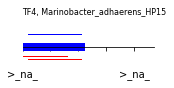

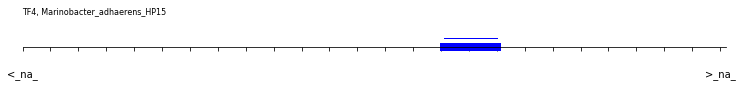

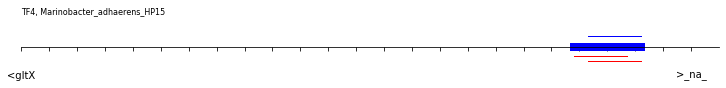

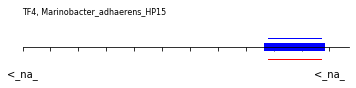

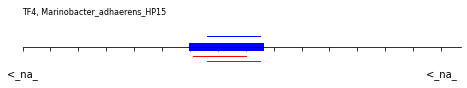

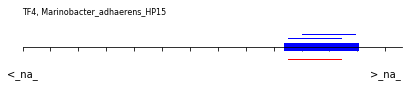

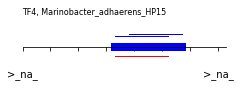

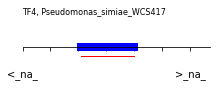

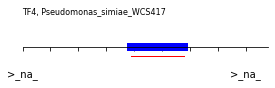

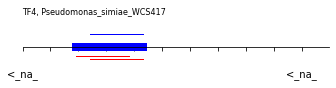

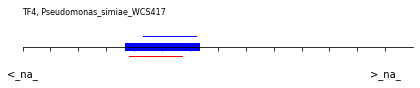

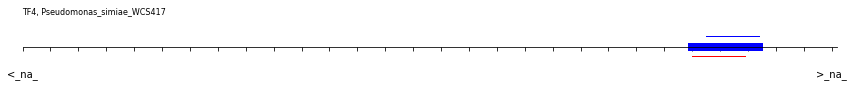

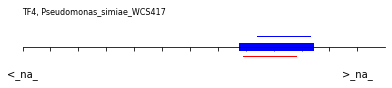

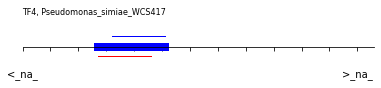

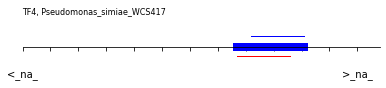

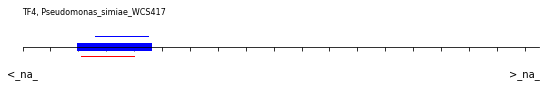

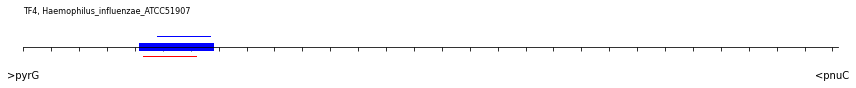

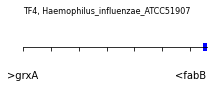

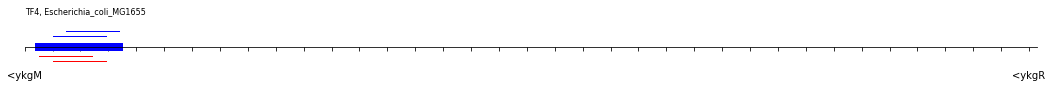

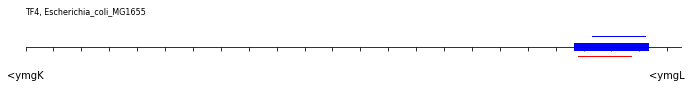

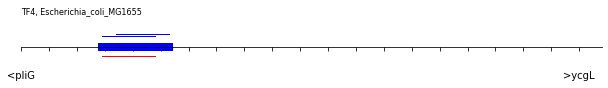

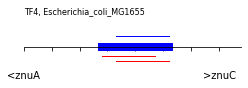

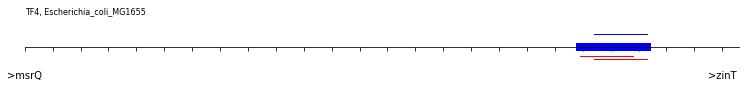

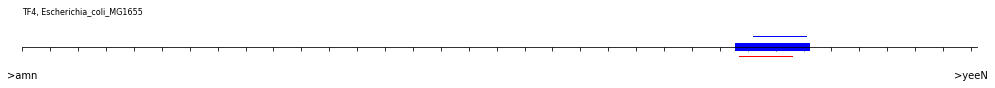

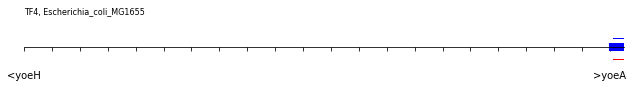

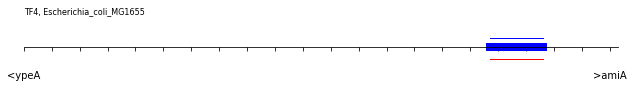

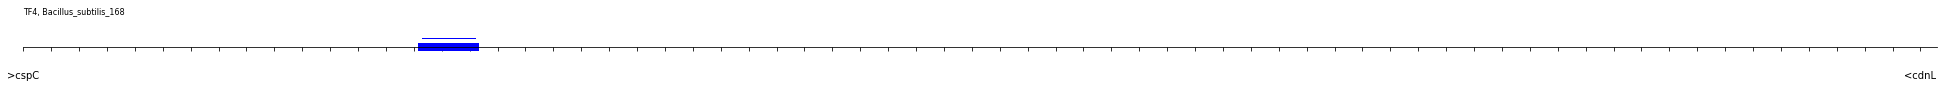

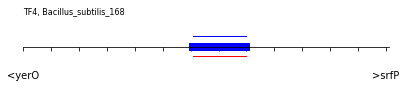

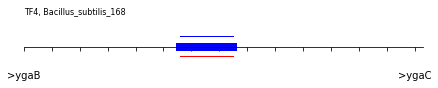

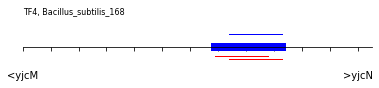

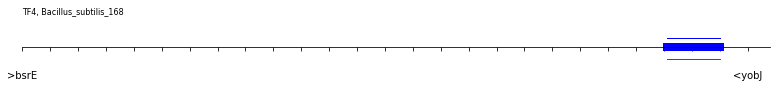

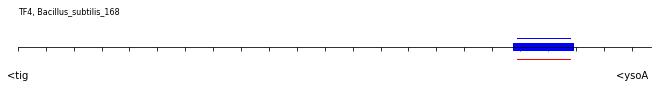

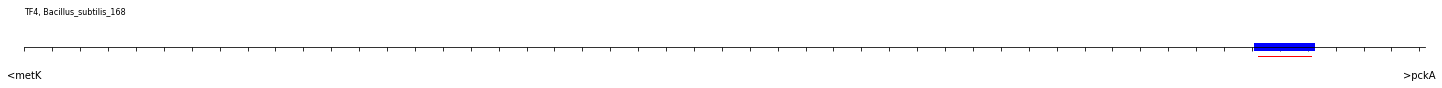

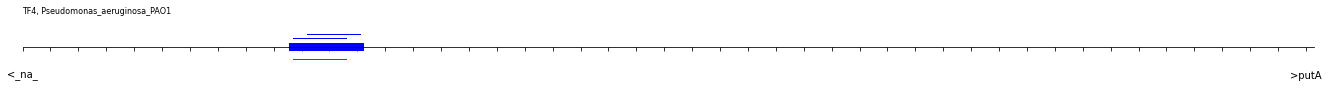

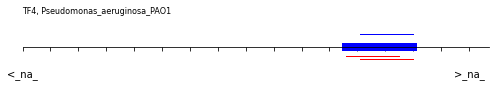

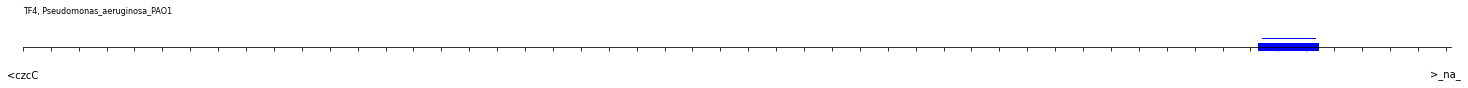

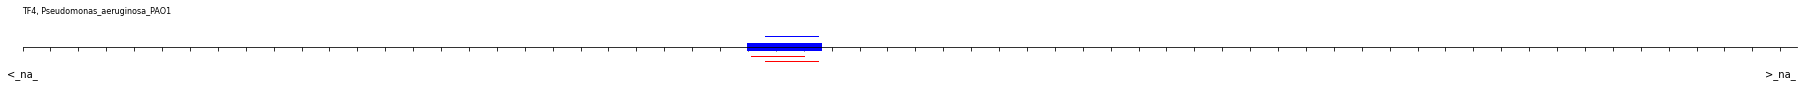

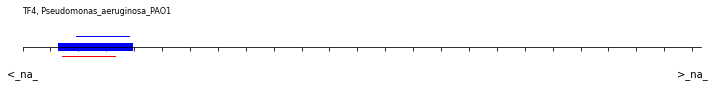

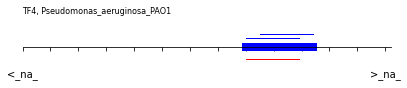

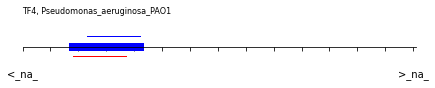

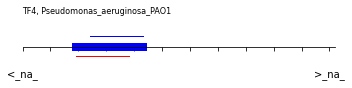

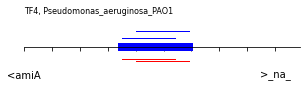

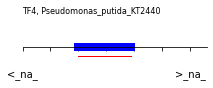

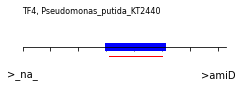

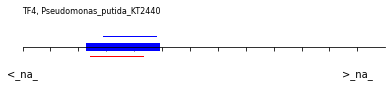

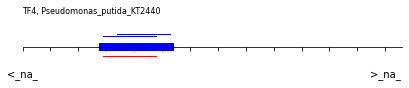

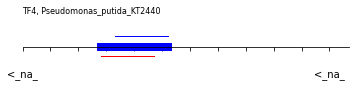

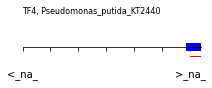

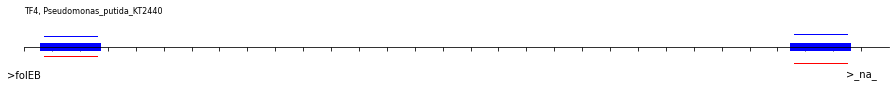

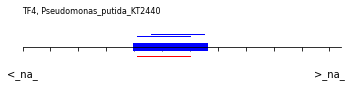

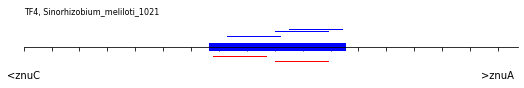

In [36]:
df_groups = df.groupby(['tf_id','intergenic_label'])
i = 0
for group_name, df_group in df_groups:
    #print(group_name, len(df_group))
    plot_intergenic_region(df_group)
    i += 1
    if i>50:
        break

In [34]:
for ix, row in df_group.iterrows():
    species = row.species
    tf_id   = str(row.tf_id)
    u = row.u_name
    d = row.d_name
    print(species, tf_id, u, d)
    

Marinobacter_adhaerens_HP15 4 _na_ _na_
Marinobacter_adhaerens_HP15 4 _na_ _na_
Marinobacter_adhaerens_HP15 4 _na_ _na_
